## Audio classification

In [1]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, ASTConfig
import torch
from datasets import load_dataset
import numpy as np
import librosa
# from IPython.display import Audio
from scipy.io.wavfile import write as write_wav
import IPython.display as ipd

## Load audio dataset hugging face

In [3]:
## hugging face dataset
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation", trust_remote_code=True)
dataset = dataset.sort("id")

print(dataset)
print(dataset.features["audio"])
sampling_rate = dataset.features["audio"].sampling_rate

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})
Audio(sampling_rate=16000, mono=True, decode=True, id=None)


## create custom audio dataset

In [2]:
# sr = 18000 # sample rate
# # convert wav file to numpy array y
# y, sr = librosa.load(wavfile)

from datasets import Dataset, Audio, ClassLabel, Features

# Define class labels
class_labels = ClassLabel(names=["speech", "music"])
# Define features with audio and label columns
features = Features({
    "audio": Audio(sampling_rate=16000),  # Define the audio feature
    "labels": class_labels  # Assign the class labels
})
# Construct the dataset from a dictionary
dataset_cust = Dataset.from_dict({
    "audio": ["/home/avncalst/bark/demo.wav", "/home/avncalst/bark/ImperialMarch60.wav","/home/avncalst/bark/test_mix.wav","/home/avncalst/bark/bark_generation.wav"],
    "labels": [0, 1,1,0],  # Corresponding labels for the audio files  
}, features=features)
sampling_rate = dataset_cust[1]["audio"]['sampling_rate']

In [3]:
print(dataset_cust[3])


{'audio': {'path': '/home/avncalst/bark/bark_generation.wav', 'array': array([4.81676136e-04, 3.69664253e-04, 8.49656208e-05, ...,
       1.46597449e-04, 1.81015625e-04, 1.48359497e-04]), 'sampling_rate': 16000}, 'labels': 0}


## Create model

In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
config = ASTConfig.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
print("number of labels:",config.num_labels)
# print(config.label2id)

number of labels: 527


## Decode audio file

In [5]:
inputs = feature_extractor(dataset_cust[3]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
print(dataset_cust[0]["audio"]["array"])

[0.08157842 0.10784451 0.08853026 ... 0.00031341 0.00036441 0.00029532]


In [6]:
audio_array = dataset_cust[3]["audio"]["array"]
ipd.Audio(audio_array,rate=sampling_rate)

In [34]:
write_wav("test.wav", sampling_rate, dataset_cust[0]["audio"]["array"])

## Classify audio

In [7]:
with torch.no_grad():
    logits = model(**inputs).logits
output = torch.sigmoid(logits)

b = output > 0.1 # threshold
indices = b.nonzero()
sum = {}
for k in range(len(indices)):
    pos = indices.data[k,1].item()
    # print(model.config.id2label[pos],round(((output.data[0,pos].item())*100),2))
    sum[model.config.id2label[pos]] = round(((output.data[0,pos].item())*100),2)
print('results (%):','\n',sum)

results (%): 
 {'Speech': 66.9, 'Female speech, woman speaking': 12.92, 'Narration, monologue': 14.95, 'Speech synthesizer': 30.18}


## Loss

In [8]:
target_label = model.config.id2label[0]
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
print(round(loss.item(),2))

0.37


## waveform

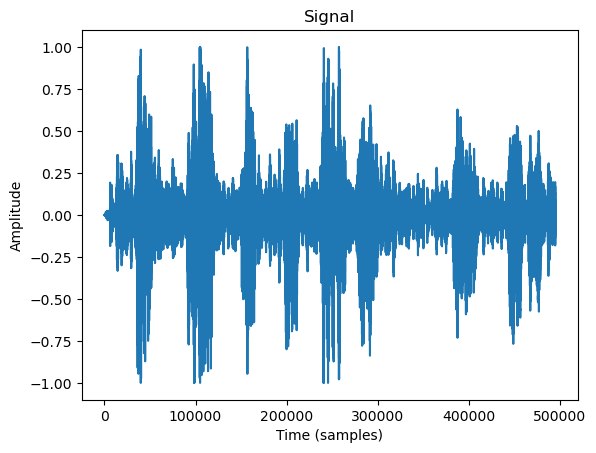

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
y,sampling_rate = librosa.load('/home/avncalst/bark/test_mix.wav')
plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

## frequency spectrum

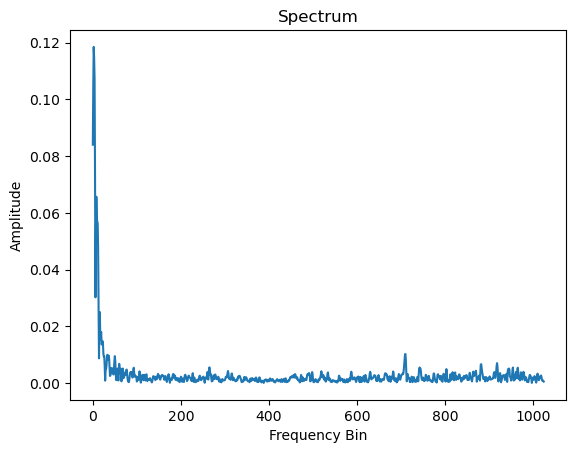

In [9]:
import numpy as np
n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

## spectrogram

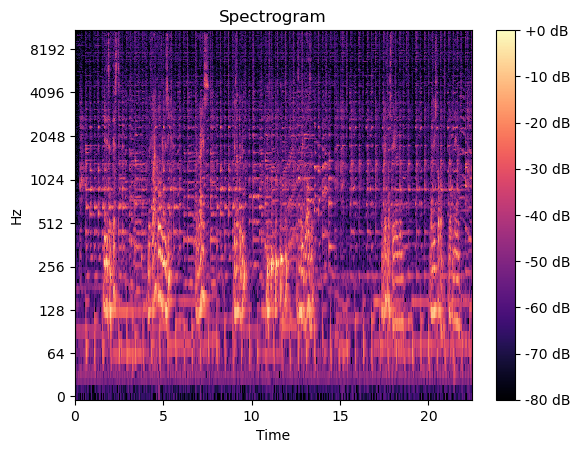

In [12]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

## mel spectorgram

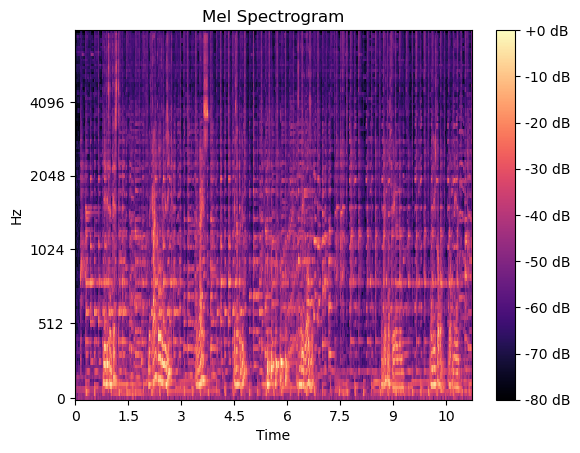

In [13]:
mel_spect = librosa.feature.melspectrogram(y=y, sr=sampling_rate, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');